<h2>Topographic Classification: A Machine Learning Approach (Exploratory Analysis Notebook)</h2>

<h3>The data:</h3>
1. The raw data from which the standard deviation products that follow are generated is a the GTOPO30 topographic digital elevation model from NOAA.
2. Fall-line data for NY, PA, MD, DE, and VA from USGS: https://pubs.usgs.gov/of/2005/1325/
3. Fall-line data for AL, MS, FL, GA, SC, NC from: https://pubs.usgs.gov/of/2005/1323/

We won't use AL and MS in this preliminary work, but they could prove useful later.


**Fall-line [source] projection params. for NY, PA, DE, MD, VA, FL, GA, SC, and NC:**
Projection: Lambert Conformal Conic<br />
Horizontal datum: NAD 27<br />
Spheroid: Clarke, 1866<br />
Standard parallels: 33 degrees North 45 degrees North<br />
Central meridian: -100 degrees<br />
Reference Latitude: 0 degrees<br />
Horizontal units: meters<br />
False easting: 0<br />
False northing: 0<br />

<h3>The derivative data products:</h3>

<h4>1. Preparing the DEM from the GTOPO30 data:</h4>
**join or merge two GeoTif DEMs:** (http://www.gdal.org/gdal_merge.html)
gdal_merge.py -ot Float32 -o /Users/paulp/Downloads/dems/gt30w100n4090.tif -of GTiff /Users/paulp/Downloads/dems/gt30w100n90.dem /Users/paulp/Downloads/dems/gt30w100n40.dem

**to clip DEM to area of interest...** (http://www.gdal.org/gdal_translate.html) 
gdal_translate -of GTiff -ot Float32 -projwin -87.2164062867 43.5271520921 -66.45458687 27.7174503169  -co COMPRESS=DEFLATE -co PREDICTOR=1 -co ZLEVEL=6 /Users/paulp/Downloads/dems/gt30w100n4090.tif /Users/paulp/Downloads/dems/us_atlantic.tif

**project the clipped GeoTif, which is currently stored in unprojected GCS, to a regional Lambert Conformal Conic...** (http://www.gdal.org/gdalwarp.html)
gdalwarp -s_srs EPSG:4326  -t_srs '+proj=lcc +lat_1=33.0  +lat_2=40.0  +lat_0=36.5 +lon_0=-77.0  +x_0=0 +y_0=0 +a=6378160 +b=6356775 +units=m +no_defs' /Users/paulp/Downloads/dems/us_atlantic.tif /Users/paulp/Downloads/dems/us_atlantic_LCC.tif

**Lambert Conformal Conic projection info:**
+proj=lcc +lat_1=33.0  +lat_2=40.0  +lat_0=36.5 +lon_0=-77.0  +x_0=0 +y_0=0 +a=6378160 +b=6356775 +units=m +no_defs

**GTOPO30 data resolution 30 arc secs or about 1 km**



<h4>2. Preparing the vector shoreline from the World Vector Shoreline data</h4>
**Create a 'clip-box' polygon in QGIS to extract a shoreline geography that matches the extent of the DEM...**<br />
-87.2164062867 43.5271520921 -66.45458687 27.7174503169
and clip out that section of the WVS
Project the resulting shoreline section into the custom LCC for the prototype

**Load the DEM and shoreline into GRASS** (v.in.ogr) <br />
**Set a mask using the shoreline polygon** (r.mask)



<h4>3. Generating the random sample observation set:</h4>
**generate a set of 7000 random points across the field **<br />
r.random input=us_atlantic_elev_LCC npoints=7000 vector=u3krandompts

**add the columns: x, y, z, slope, and distance to the new random points layer FAT:**<br />
v.db.addcolumn map=u3krandompts columns='x double precision, y double precision, z double precision, slope double precision, distance double precision'

**add x and y coordinates of each sample point to the points data FAT:**<br />
v.to.db map= u3krandompts type=point option=coor columns=x,y

**add slope values to sample points FAT:**<br />
v.what.rast map=u3krandompts raster=us_atlantic_slope_LCC@user column=slope

**conflate value column contents to z:**<br />
v.db.update map=u3krandompts layer=1 column=z query_column=value

**drop column value as it is now redundant with the newly added, and more descriptive, z:**<br />
db.dropcolumn -f table=u3krandompts column=value

**compute the distance from each sample point to the nearest shoreline segment:**<br />
v.distance from=us3krandompts from_type=point to=US_Atl_Shoreline_LCC upload=dist column=distance


**and then, continue on in Jupyter...**

**Load the requisite libraries, modules, and magics:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kde import KDEUnivariate

sns.set()
%matplotlib inline

**Load the sample point data from GRASS:**

In [19]:
### Load the Data from the GRASS (SQLITE3) database:

### to read the GRASS attribute table: u3krandompts into pandas (Note that there are actually
### 7,000 points in the file...)
datapath='/Users/paulp/GoogleDrive/projects/GRASSData/USAtl_CoastalPlain_Prototype_LCC/user/sqlite/'
fn='sqlite.db' 

conn=sqlite3.connect(datapath+fn)   # create a connection to the database file:

# with the first load and subsequent plot (scatters in next cell) we discovered that there was
# an errant value with a z value of approx. -10,000 meters!. Since the data comes to us from 
# the GTOPO30 dataset, we know that there should be no elevation < 0 meters, so we adjust the
# sSQL select statement to weed this outlier from our data before we proceed...
df = pd.read_sql_query('select * from u3krandompts where z > 0.0', conn)

print('Some simple descriptive statistics for the sample point dataset:')
print('Note that position and distance units are in meters. Slope is in degrees of arc.')
df.describe()

Some simple descriptive statistics for the sample point dataset:
Note that position and distance units are in meters. Slope is in degrees of arc.


,cat,x,y,z,slope,distance,label
count,6839.000000,6839.000000,6839.000000,6839.000000,6839.000000,6839.000000,1477.0
mean,3579.940050,-333330.901827,196692.273118,250.278403,1.290012,337162.680547,1.0
std,1975.937644,325420.148830,413964.610538,203.131213,5.315937,253322.510692,0.0
min,8.000000,-898697.654090,-963789.102542,1.000000,0.000000,40.911268,1.0
25%,1870.500000,-587704.714494,-99955.509085,101.000000,0.123658,117461.126241,1.0
50%,3581.000000,-384709.323053,257975.540056,223.000000,0.431864,287217.486331,1.0
75%,5290.500000,-101215.759144,550919.108207,328.000000,1.078761,523218.957013,1.0
max,7000.000000,573268.928180,816867.876563,1584.000000,79.858860,977011.224148,1.0


**Some simple scatter plots of the sample point data - using all of the 7000 observations**

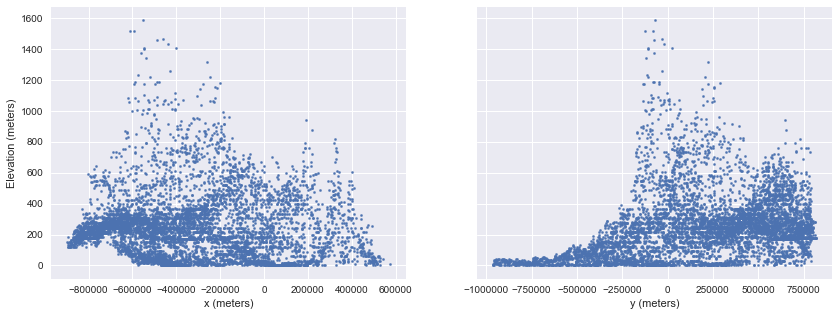

In [4]:
### SCATTER PLOT: ELEVATION vs. X and Y coordinates (spatial distribution of elevations):

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

ax1.scatter(df.x, df.z, s=5.0)
ax1.set_xlabel('x (meters)')
ax1.set_ylabel('Elevation (meters)')

ax2.scatter(df.y, df.z, s=5.0)
ax2.set_xlabel('y (meters)')

Plots of the entire 7000 point sample set. On the left is a plot of elevation across the x-axis of the LCC coordinate system; on the right are  the same elevations along the y-axis. Neither cloud is particularly revealing, though the narrow horizontal point bands see across the bottom of both plots does suggest(1) a topographic signal dominated  by the low, gently sloping coastal plain: in the right hand plot the low "platform" on the left perhaps representing the low lands across S. Georgia and Northern and Central Florida(1). As we move to the right on that same plot we see the conuation of the coastal plain (as the low elevation horizontal band in the foreground) and the rise of the Appalachian Mountains from south northward.

(1) Phantom 'signal' perhaps? Or maybe, I see the coastal plain in the data because I really want to see a coastal plain in the data? 

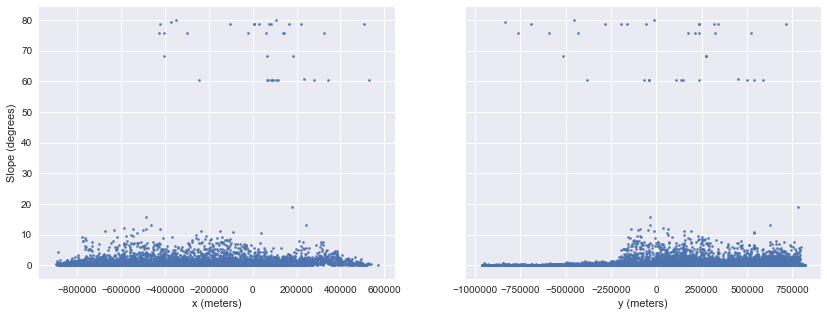

In [5]:
### SCATTER PLOT: topographic slope vs. X and Y coordinates (spatial distribution of slopes):

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

ax1.scatter(df.x, df.slope, s=5.0)
ax1.set_xlabel('x (meters)')
ax1.set_ylabel('Slope (degrees)')

ax2.scatter(df.y, df.slope, s=5.0)
ax2.set_xlabel('y (meters)')

Plot of topographic slope (computed as first derivative of elevation) along the projection x-axis (left plot) and y-axis (right plot). Two things to glean here: first, the distribution of slopes across the entire area rarely exceeds 10 degrees, and second, in the right plot we see (I think) the relatively "very" flat areas in the south (Florida and S. Georgia) grading into the more varied landscapes seen as we move from south to north (left to right). The coastal plain (our geomorphic feature of interest) is easily seen (or is it?) in the south. Northward, the backgound mountain slopes mask (to some degree) the gentle foreground of the coastal plain. Still, there is a coastal plain seen in these plots(1). Question is: can we discriminate between slopes (and elevations, too) between that coastal plain and elsewhere? 

(1) see footnote in commentary associated with the elevation distribution plots, above.

**Some simple scatter plots of the sample point data - using only observations where slope is <= 0.69 degrees**

Based on Paris, Walsh, and Corbett, 2016, we can extend the constraint placed on continental shelf slopes to its subaerial component, the coastal plain, by subsetting the original 7000 point sample set into a subgroup containing only those points where the topographic slope is <= 0.69 degrees. 

In [20]:
# Extract a new dataframe from the query results where slopes are <= 0.69 degrees:
df2=df.query('slope <= 0.69')
print('Some simple descriptive statistics for the slope-constrained subset:')
print('Note that position and distance units are in meters. Slope is in degrees of arc.')
df2.describe()

Some simple descriptive statistics for the slope-constrained subset:
Note that position and distance units are in meters. Slope is in degrees of arc.


,cat,x,y,z,slope,distance,label
count,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,1411.0
mean,3749.036977,-376855.560981,147067.854859,170.267622,0.235593,347593.646156,1.0
std,2139.917182,309513.680648,460899.747436,130.148352,0.202310,284643.692174,0.0
min,8.000000,-898697.654090,-963789.102542,1.000000,0.000000,106.692903,1.0
25%,1837.500000,-615204.090181,-224931.434064,46.000000,0.057307,87219.357137,1.0
50%,3727.000000,-432708.233344,232980.355060,176.000000,0.182628,272398.585121,1.0
75%,5828.000000,-160714.408360,553918.530407,258.000000,0.395545,593118.953591,1.0
max,7000.000000,573268.928180,816867.876563,920.000000,0.689084,977011.224148,1.0


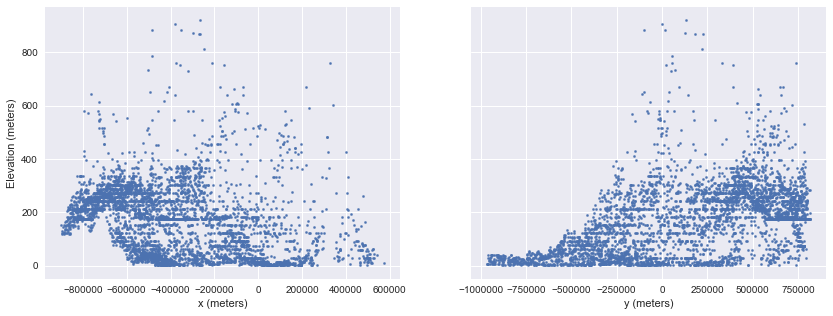

In [7]:
### SCATTER PLOT: ELEVATION vs. X and Y coordinates (spatial distribution of elevations):
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

ax1.scatter(df2.x, df2.z, s=5.0)
ax1.set_xlabel('x (meters)')
ax1.set_ylabel('Elevation (meters)')

ax2.scatter(df2.y, df2.z, s=5.0)
ax2.set_xlabel('y (meters)')

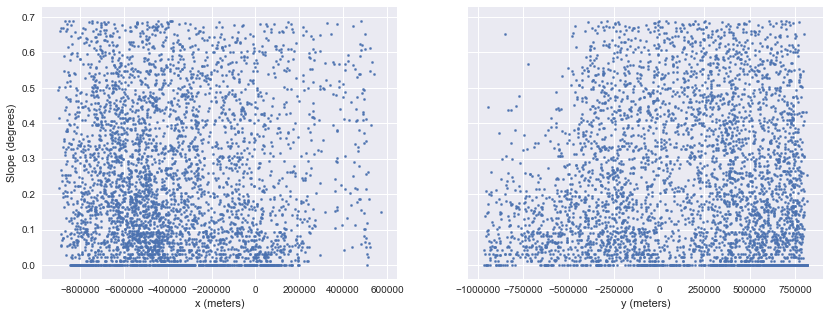

In [8]:
### SCATTER PLOT: SLOPE vs X and Y coordinates (spatial distribution of slopes):
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

ax1.scatter(df2.x, df2.slope, s=5.0)
ax1.set_xlabel('x (meters)')
ax1.set_ylabel('Slope (degrees)')

ax2.scatter(df2.y, df2.slope, s=5.0)
ax2.set_xlabel('y (meters)')

I envision that the thin horizontal bands that are seen across the bottom of both plots is tied, in large measure, to coastal plain topography in the foreground. The mass of points raining down from the top of the plots are representative of both the greater absolute slopes and variation in slope seen across the uplands and background mountain ranges.

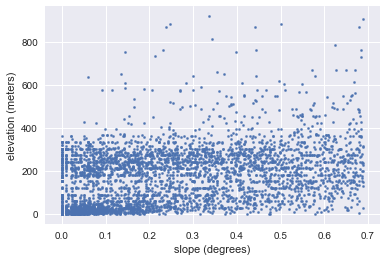

In [9]:
### SCATTER PLOT: ELEVATION vs SLOPE
plt.scatter(df2.slope, df2.z, s=5.0)
plt.ylabel('elevation (meters)')
plt.xlabel('slope (degrees)')

Two horizontal bands are seen across the plot's bottom. Could it be a reasonable assumption that the band from z=0 to about 125 to 150 m represent a 'coastal plain'? If so, or for whatever it truly represents, can we detect it?

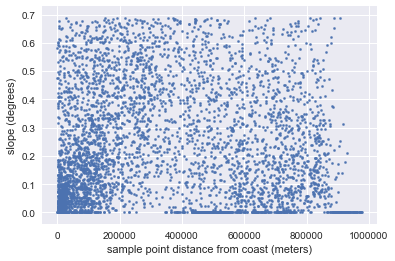

In [10]:
### SCATTER PLOT: SLOPE vs DISTANCE FROM COASTLINE:
plt.scatter(df2.distance, df2.slope, s=5.0)
plt.xlabel('sample point distance from coast (meters)')
plt.ylabel('slope (degrees)')

Hmm...

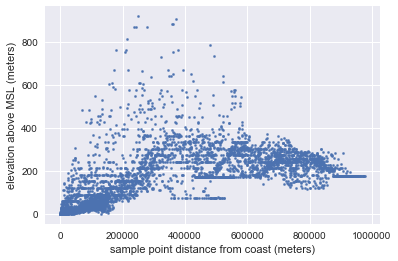

In [11]:
### SCATTER PLOT: ELEVATION vs SAMPLE POINT DISTANCE FROM COASTLINE:
plt.scatter(df2.distance, df2.z, s=5.0)
plt.xlabel('sample point distance from coast (meters)')
plt.ylabel('elevation above MSL (meters)')

**Kernel Density Estimates**

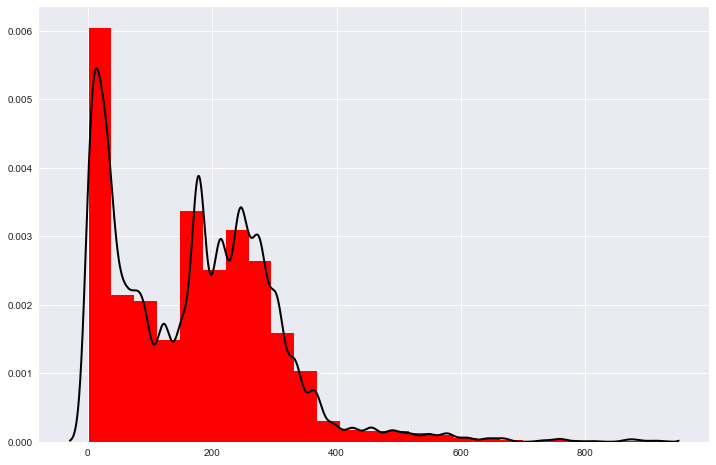

In [12]:
### KDE for ELEVATION:
kde = KDEUnivariate(df2.z)
kde.fit(bw=10.0)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hist(df2.z, bins=25, normed=True, color='red')
ax.plot(kde.support, kde.density, lw=2, color='black');
#ax.set_xlim(0,100)
#ax.plot(kde.support, kde.cdf)

The distribution of elevations is distinctly bi-model (with some suggestion of tri-modality, but we ignore this, chalking it up to an artifact associated with the present selection of bins and bandwidth). Most of the elevations are concentrated in the second mode, but it is perhaps in the first peak that we might assume our coastal plain exists. Maybe...

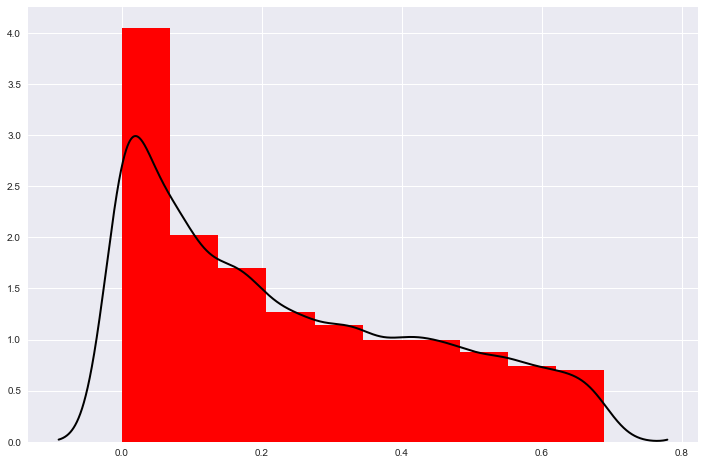

In [13]:
### KDE for SLOPES:
kde = KDEUnivariate(df2.slope)
kde.fit(bw=0.03)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hist(df2.slope, bins=10, normed=True, color='red')
ax.plot(kde.support, kde.density, lw=2, color='black');

Here we find that most of the slopes are concentrated in a range between about 0.3 degrees and flatness. Otherwise, the plot doesn't immediately give us much help in isolating the coastal plain province from everything else. 

The final metric, distance from the shore, would be expected to reveal little in a KDE for it's bult from a set of randomly distributed sample points spread across the study region. That we've subset the data based on our slope criteria (slope <= 0.69 degrees) does, however, offer up the possibility that something might be revealed in the distribution of the remaining points. Let's see...

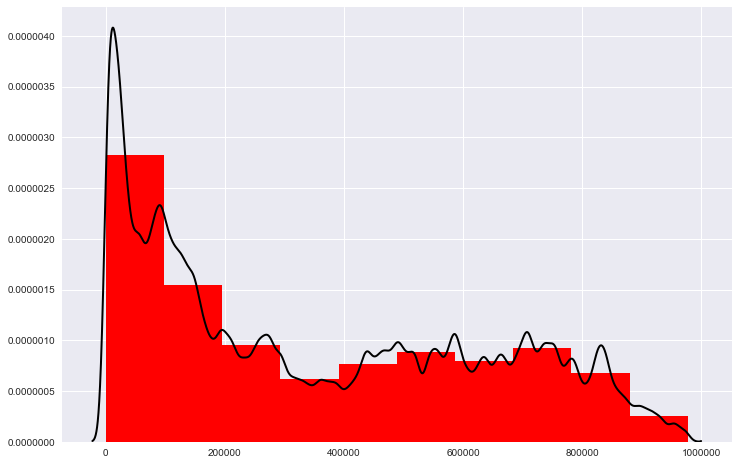

In [14]:
### KDE for DISTANCE to COASTLINE:
kde = KDEUnivariate(df2.distance)
kde.fit(bw=7500.0)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hist(df2.distance, bins=10, normed=True, color='red')
ax.plot(kde.support, kde.density, lw=2, color='black');

There's a whole bunch of variance in the data (note the irregular KDE, and this with a bandwidth of 7500!) but it would appear that we can see a large number of sample points siting in close proximity to the coast--as we expected, right? 

It might be possible that a well-executed unsupervised classifier can separate the observations that occur less than about 300,000 meters (~300 km or ~180 statute miles) from the coast. Note that these are aggregate numbers. They do not everywhere, perhaps even anywhere, reflect the actual width of the coastal plain. Honestly though, I doubt it would present a clean, definitive, convincing partitioning of the data---the world is simply too complicated.